In [2]:
from fl_puf.Utils.tabular_data_loader import load_dutch 
import matplotlib.pyplot as plt

In [3]:
df, columns, metadata = load_dutch(dataset_path="./data/Tabular/dutch/")

In [4]:
df.head()

,age,household_position,household_size,prev_residence_place,citizenship,country_birth,edu_level,economic_status,cur_eco_activity,Marital_status,sex_binary,occupation_binary
0,6,1131,112,1,1,1,5,111,135,1,1,0
1,10,1122,113,1,1,1,2,111,122,2,0,1
2,8,1122,113,1,1,1,2,111,122,2,1,0
3,12,1121,112,1,1,1,1,111,137,2,1,1
4,4,1110,114,1,1,1,2,111,138,1,0,1


<Axes: >

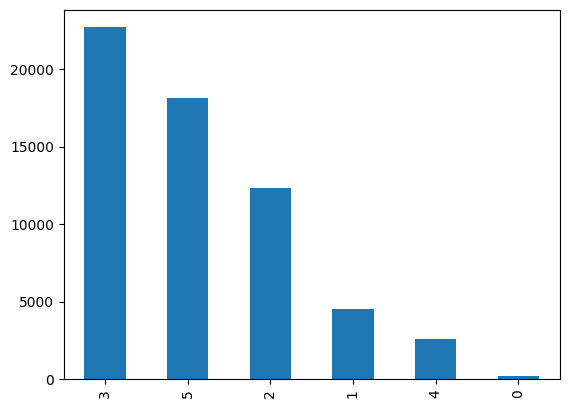

In [5]:
df.edu_level.value_counts().plot(kind='bar')

In [7]:
import torch 
datasets = []
for node in range(0,150):
    datasets.append(torch.load(f"./data/Tabular/dutch/federated/{node}/train.pt"))

In [11]:
from DPL.RegularizationLoss import RegularizationLoss

In [24]:
nodes = {}

In [19]:
disparities = []
for dataset in datasets:
    sensitive_values = []
    for sample in dataset.samples:
        sensitive_values.append(sample[6])
    targets = dataset.targets
    sensitive_values = [torch.tensor(1) if item != 0.6 else torch.tensor(0) for item in sensitive_values]
    max_disparity = max([RegularizationLoss().compute_violation_with_argmax(
            predictions_argmax=targets,
            sensitive_attribute_list=sensitive_values,
            current_target=target, 
            current_sensitive_feature=sv,
        )for sv in [0,1] for target in [0,1]]
        )
    disparities.append(max_disparity)

In [21]:
disparities_original = []
for dataset in datasets:
    sensitive_values = []
    targets = dataset.targets
    sensitive_values = dataset.sensitive_features
    max_disparity = max([RegularizationLoss().compute_violation_with_argmax(
            predictions_argmax=targets,
            sensitive_attribute_list=sensitive_values,
            current_target=target, 
            current_sensitive_feature=sv,
        )for sv in [0,1] for target in [0,1]]
        )
    disparities_original.append(max_disparity)

In [25]:
for node_name, (d, do) in enumerate(zip(disparities, disparities_original)):
    nodes[node_name] = {"education": d, "original": do}

In [29]:
# sort the dictionary by original
nodes = dict(sorted(nodes.items(), key=lambda item: item[1]["original"], reverse=False))

In [30]:
nodes

{35: {'education': 0.5043731778425656, 'original': 0.14297921793820068},
 32: {'education': 0.5510204081632653, 'original': 0.20612036722203336},
 50: {'education': 0.5306122448979592, 'original': 0.21230873852431148},
 19: {'education': 0.5306122448979592, 'original': 0.21639400136332648},
 26: {'education': 0.5510204081632653, 'original': 0.21666666666666667},
 43: {'education': 0.5335276967930029, 'original': 0.21673133210809337},
 17: {'education': 0.5072886297376094, 'original': 0.22428571428571425},
 15: {'education': 0.5189504373177842, 'original': 0.22509011766306197},
 20: {'education': 0.5422740524781341, 'original': 0.23327207133619227},
 51: {'education': 0.5335276967930029, 'original': 0.23950810737157652},
 56: {'education': 0.5335276967930029, 'original': 0.24060432439806295},
 7: {'education': 0.5335276967930029, 'original': 0.2468883901244644},
 72: {'education': 0.5102040816326531, 'original': 0.24764150943396224},
 44: {'education': 0.5043731778425656, 'original': 0.

In [31]:
df.head()

,age,household_position,household_size,prev_residence_place,citizenship,country_birth,edu_level,economic_status,cur_eco_activity,Marital_status,sex_binary,occupation_binary
0,6,1131,112,1,1,1,5,111,135,1,1,0
1,10,1122,113,1,1,1,2,111,122,2,0,1
2,8,1122,113,1,1,1,2,111,122,2,1,0
3,12,1121,112,1,1,1,1,111,137,2,1,1
4,4,1110,114,1,1,1,2,111,138,1,0,1


In [32]:
df['edu_level'] = df['edu_level'].apply(lambda x: 1 if x == 3 else 0)

In [7]:
metadata

{'name': 'Dutch census',
 'code': ['DU1'],
 'protected_atts': ['sex_binary'],
 'protected_att_values': [0],
 'protected_att_descriptions': ['Gender = Female'],
 'target_variable': 'occupation_binary'}

In [34]:
df.drop("occupation_binary", axis=1).applay(lambda x: x.corr(df.occupation_binary))


age                    -0.261036
household_position     -0.036717
household_size         -0.011307
prev_residence_place   -0.015209
citizenship             0.036975
country_birth           0.062500
edu_level               0.187676
economic_status        -0.215863
cur_eco_activity        0.034301
Marital_status         -0.086747
sex_binary             -0.298820
dtype: float64

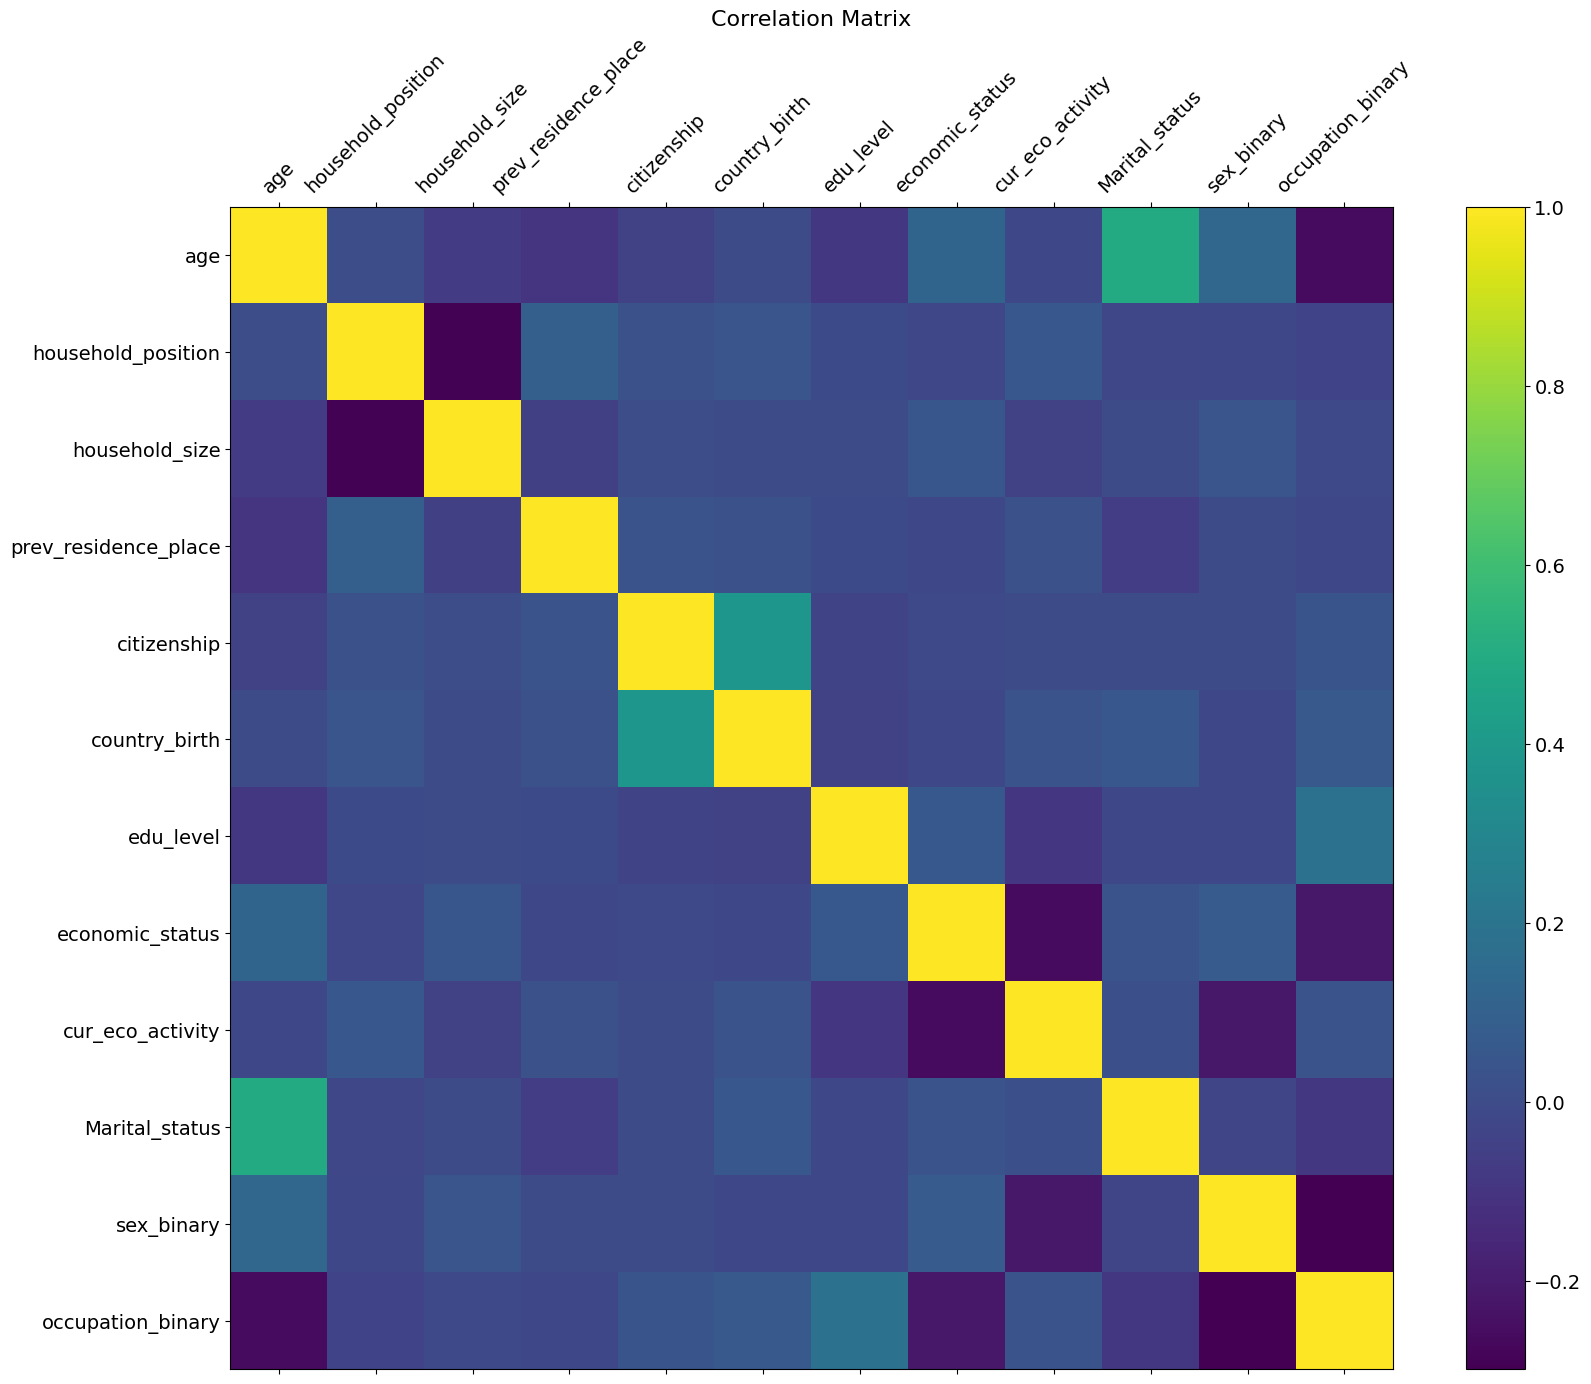

In [35]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);